In [1]:
import pandas as pd

In [2]:
data_folder = "../data"
pics_folder = "../pics/1"

In [3]:
df_0 = pd.read_csv(f'{data_folder}/nn_0.csv').rename(columns=str.lower)
df_1 = pd.read_csv(f'{data_folder}/nn_1.csv').rename(columns=str.lower)

In [4]:
df_0

,x1,x2,class
0,1.017522,1.543864,-1
1,1.151304,1.724181,-1
2,1.050958,1.119564,-1
3,1.036791,0.955846,-1
4,1.154825,0.761754,-1
...,...,...,...
95,-0.414244,-0.018218,1
96,0.083760,0.185509,1
97,-0.239337,0.298548,1
98,0.196957,-0.198677,1


<Axes: >

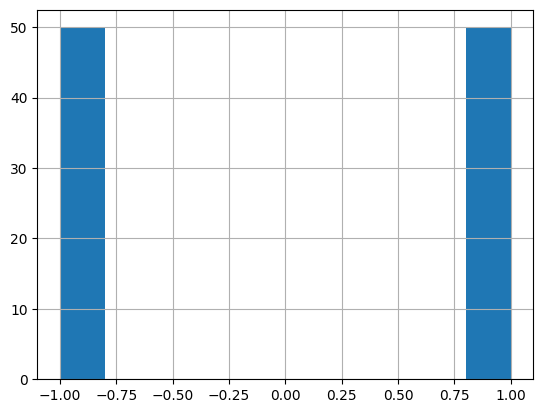

In [5]:
df_0["class"].hist()

In [6]:
df_0["class"] = df_0["class"].map({-1: 0, 1: 1})

In [7]:
df_0.describe()

,x1,x2,class
count,100.000000,100.000000,100.000000
mean,0.507212,0.516565,0.500000
std,0.548515,0.580965,0.502519
min,-0.617291,-0.451399,0.000000
25%,0.033540,-0.022267,0.000000
50%,0.500174,0.484939,0.500000
75%,1.018259,0.946959,1.000000
max,1.300767,1.724181,1.000000


In [8]:
df_1

,x1,x2,class
0,-0.011802,0.040455,1
1,-0.178221,0.212999,1
2,0.061962,0.186818,1
3,0.055123,0.206935,1
4,0.203488,-0.290206,1
...,...,...,...
245,0.767424,1.173810,1
246,0.869957,1.079371,1
247,1.077572,1.057825,1
248,1.130315,0.921124,1


<Axes: >

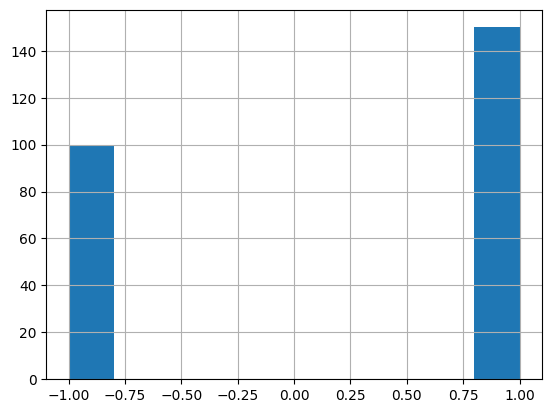

In [9]:
df_1["class"].hist()

In [10]:
df_1.describe()

,x1,x2,class
count,250.000000,250.000000,250.000000
mean,0.612516,0.596186,0.200000
std,0.449920,0.457529,0.981761
min,-0.465898,-0.474352,-1.000000
25%,0.121679,0.173469,-1.000000
50%,0.710726,0.736661,1.000000
75%,0.996934,1.000902,1.000000
max,1.470643,1.238856,1.000000


In [11]:
df_1["class"] = df_1["class"].map({-1: 0, 1: 1})

In [12]:
features = ["x1", "x2"]
target = "class"

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df_0_train, df_0_test = train_test_split(df_0, test_size=0.2, random_state=42, stratify=df_0[target])
df_1_train, df_1_test = train_test_split(df_1, test_size=0.2, random_state=42, stratify=df_1[target])

In [15]:
import torch.nn as nn

In [16]:
class SingleNeuron(nn.Module):
    def __init__(self, input_size, activation_fn):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
        self.activation = activation_fn
    
    def forward(self, x):
        return self.activation(self.linear(x))

In [17]:
import torch
from tqdm import tqdm

In [18]:
def train_model(train_data, test_data, features, target, activation_fn, optimizer_class, lr=1e-3, epochs=1_000, tol=1e-8):
    model = SingleNeuron(len(features), activation_fn)
    criterion = nn.MSELoss()
    optimizer = optimizer_class(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    X_train = torch.FloatTensor(train_data[features].values)
    X_test = torch.FloatTensor(test_data[features].values)
    y_train = torch.FloatTensor(train_data[target].values)
    y_test = torch.FloatTensor(test_data[target].values)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            test_loss = criterion(model(X_test), y_test)
            test_losses.append(test_loss.item())
            
        if epoch > 10 and (abs(test_losses[-1] - test_losses[-2]) < tol or test_losses[-1] - test_losses[-2] > 100 * tol):
            break
    
    return train_losses, test_losses, epoch+1

In [19]:
import torch.optim as optim

In [20]:
activations = {
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ReLU': nn.ReLU()
}

optimizers = {
    'SGD': optim.SGD,
    'Adagrad': optim.Adagrad,
    'RMSprop': optim.RMSprop,
}

datasets = (
    (df_0_train, df_0_test),
    (df_1_train, df_1_test)
)

In [21]:
from functools import partial

In [22]:
def eval(dataset):
    results = dict()
    train_data, test_data = dataset
    train_model_with_data = partial(
        train_model, 
        train_data=train_data,
        test_data=test_data,
        features=["x1", "x2"],
        target=["class"]
    )
    
    for act_name, act_fn in activations.items():
        for opt_name, opt_cls in optimizers.items():
            train_loss, test_loss, epochs = train_model_with_data(
                activation_fn=act_fn, 
                optimizer_class=opt_cls
            )
    
            key = f"{act_name} | {opt_name}"
            results[key] = (train_loss, test_loss, epochs)

    return results

In [23]:
results = list()
for dataset in datasets:
    results.append(eval(dataset))

 44%|████████████████████▋                          | 441/1000 [00:00<00:00, 2061.12it/s]


In [24]:
results[0].keys()

dict_keys(['Sigmoid | SGD', 'Sigmoid | Adagrad', 'Sigmoid | RMSprop', 'Tanh | SGD', 'Tanh | Adagrad', 'Tanh | RMSprop', 'ReLU | SGD', 'ReLU | Adagrad', 'ReLU | RMSprop'])

In [25]:
import matplotlib.pyplot as plt

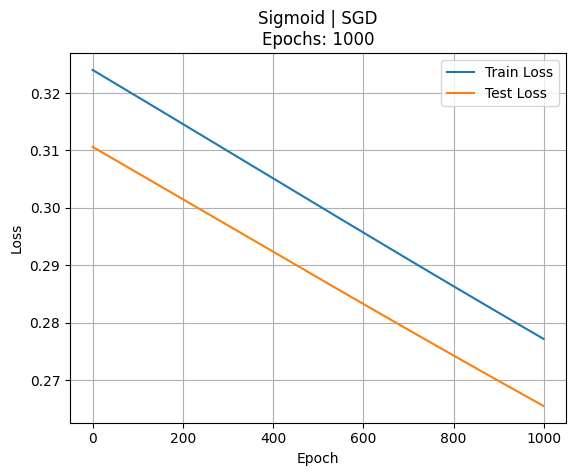

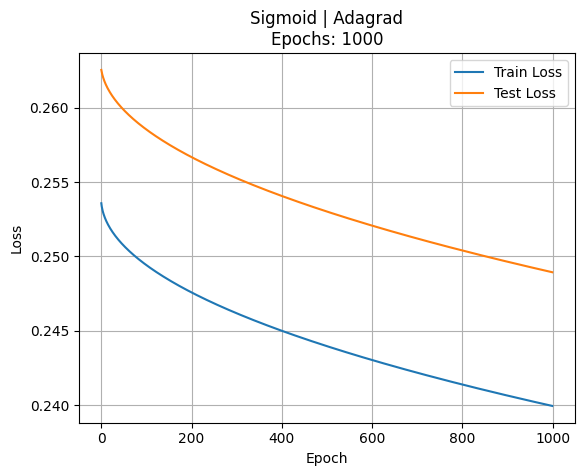

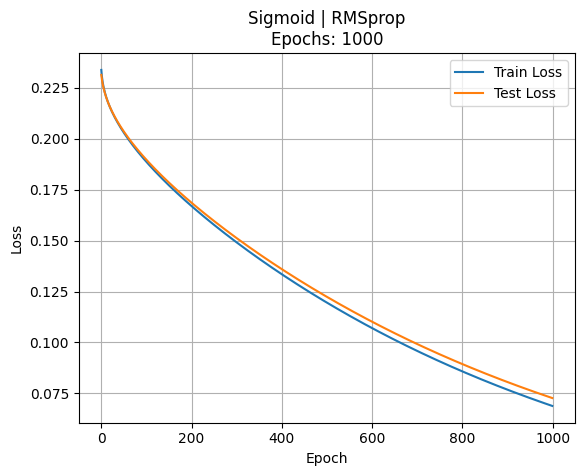

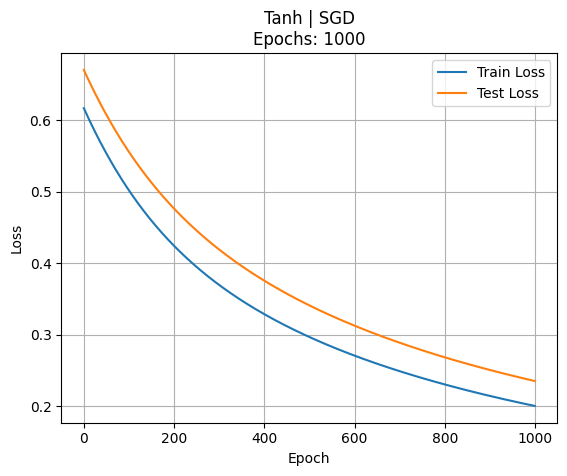

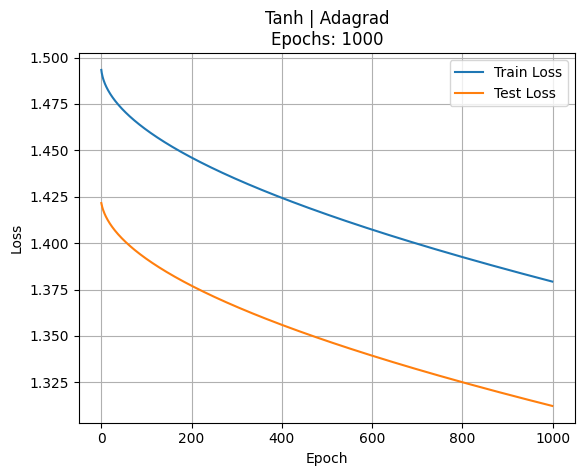

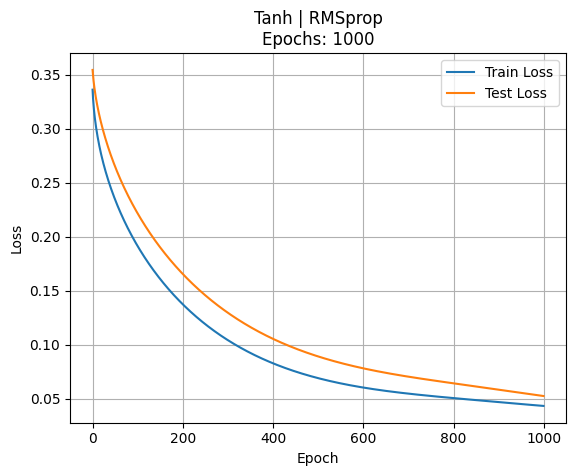

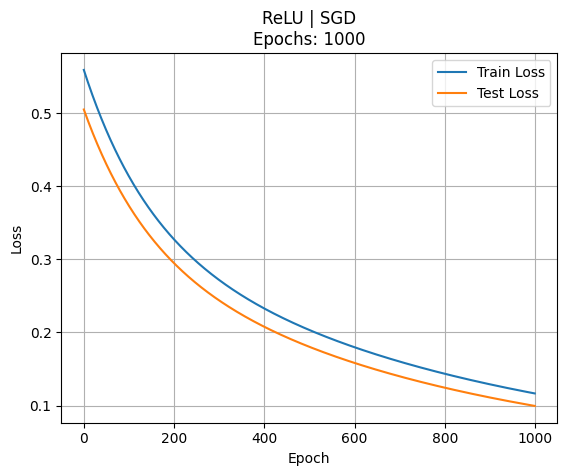

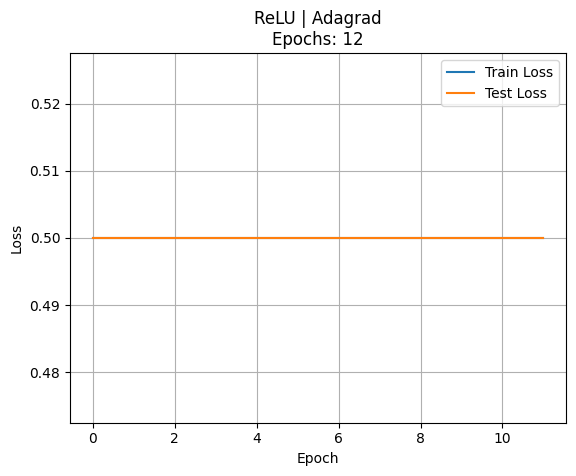

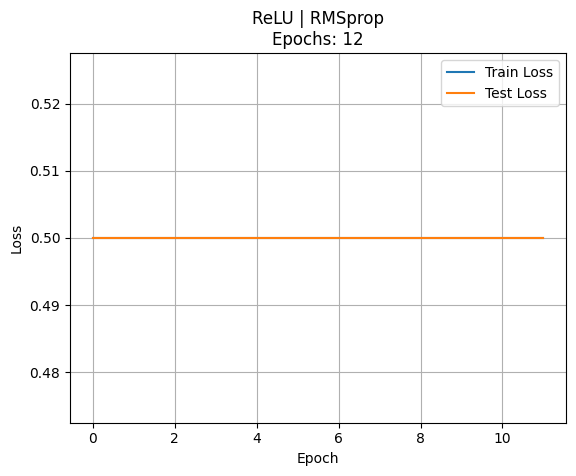

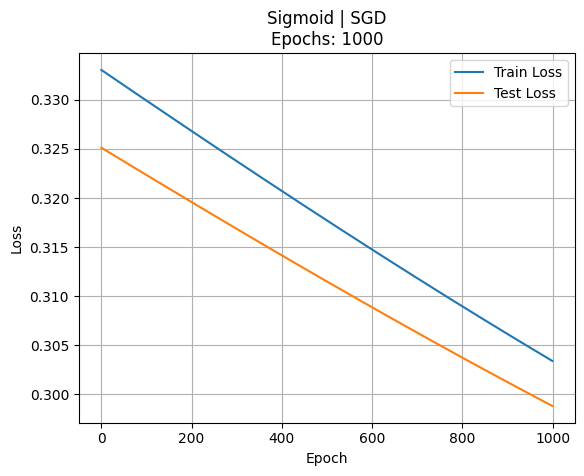

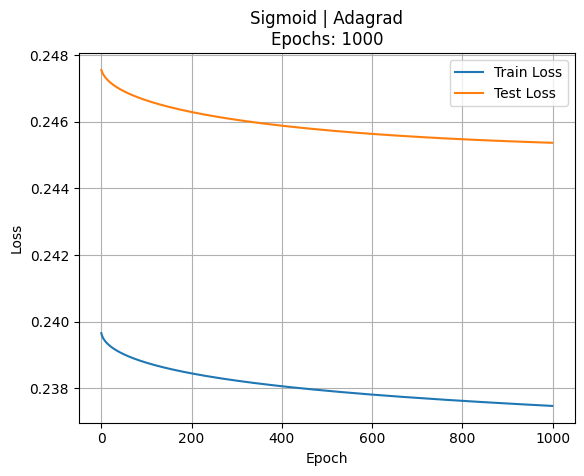

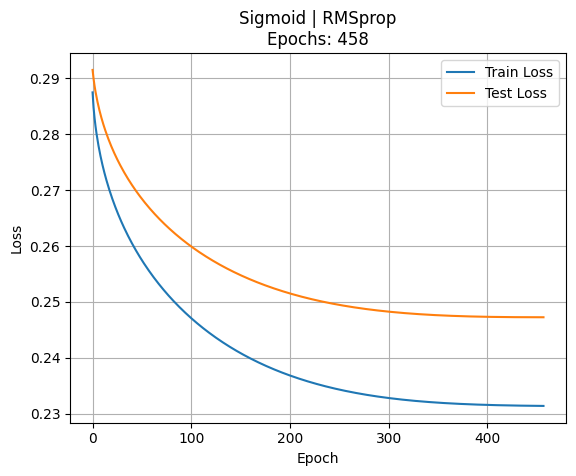

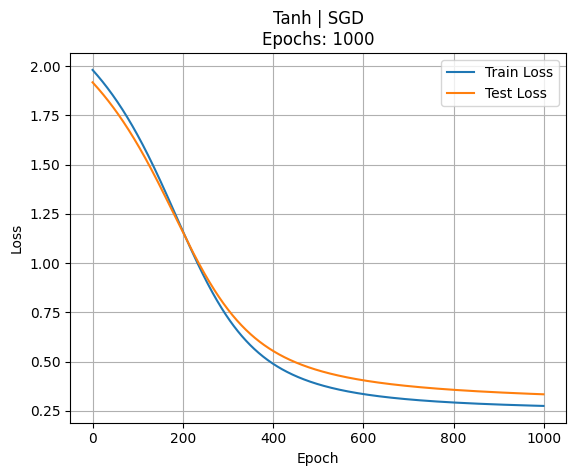

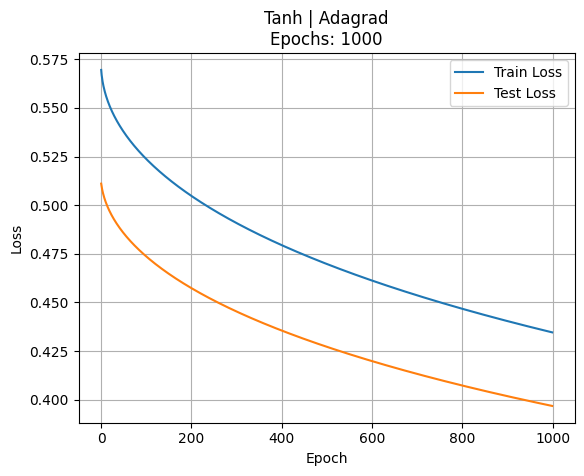

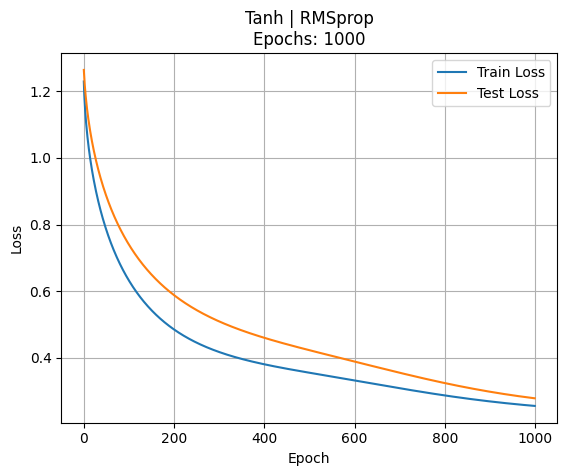

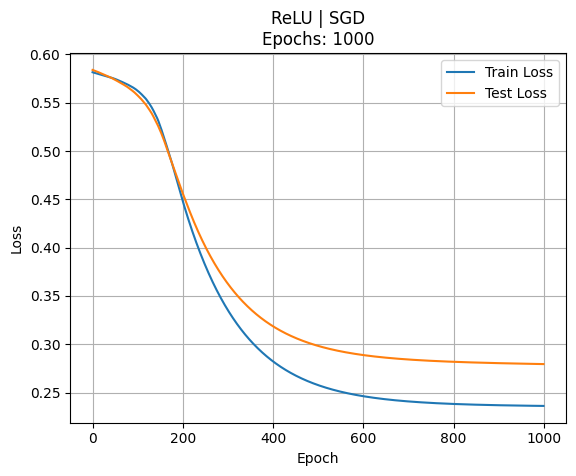

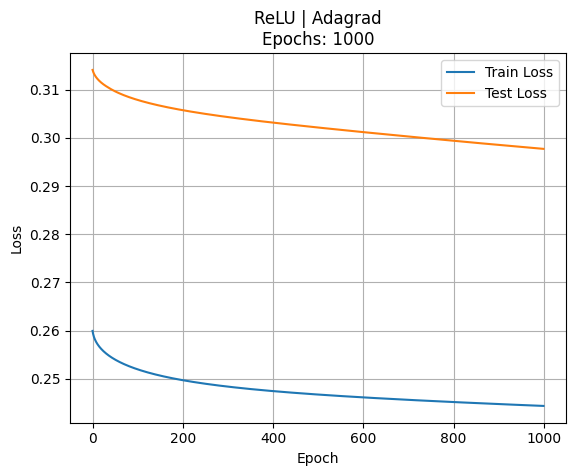

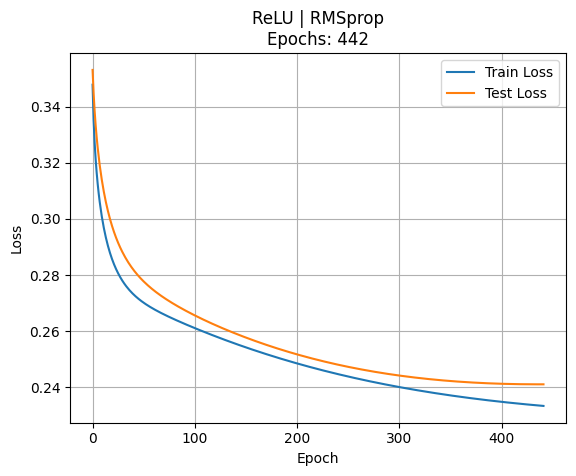

In [26]:
for i in range(2):
    for name, res in results[i].items():
        train, test, epochs = res
        plt.title(name)
        plt.title(f"{name}\nEpochs: {epochs}")
        plt.plot(train, label='Train Loss')
        plt.plot(test, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        pic_name = name.replace(" | ", "_")
        plt.savefig(f"{pics_folder}/{i}/{pic_name}.png")
        plt.show()

In [27]:
res_0_df = pd.DataFrame({
    "name" : results[0].keys(),
    "train_loss": [res[0][-1] for res in results[0].values()],
    "test_loss": [res[1][-1] for res in results[0].values()]
})

res_0_df

,name,train_loss,test_loss
0,Sigmoid | SGD,0.277181,0.265497
1,Sigmoid | Adagrad,0.239940,0.248936
2,Sigmoid | RMSprop,0.068812,0.072692
3,Tanh | SGD,0.200597,0.235402
4,Tanh | Adagrad,1.379296,1.312275
5,Tanh | RMSprop,0.043362,0.052524
6,ReLU | SGD,0.116511,0.099423
7,ReLU | Adagrad,0.500000,0.500000
8,ReLU | RMSprop,0.500000,0.500000


In [28]:
res_1_df = pd.DataFrame({
    "name" : results[0].keys(),
    "train_loss": [res[0][-1] for res in results[1].values()],
    "test_loss": [res[1][-1] for res in results[1].values()]
})

res_1_df

,name,train_loss,test_loss
0,Sigmoid | SGD,0.303394,0.298802
1,Sigmoid | Adagrad,0.237466,0.245371
2,Sigmoid | RMSprop,0.231390,0.247256
3,Tanh | SGD,0.274765,0.333809
4,Tanh | Adagrad,0.434591,0.396744
5,Tanh | RMSprop,0.255760,0.278670
6,ReLU | SGD,0.236130,0.279435
7,ReLU | Adagrad,0.244345,0.297740
8,ReLU | RMSprop,0.233298,0.241005


In [29]:
res_0_df.merge(
    res_1_df,
    on='name',
    how='left',
    suffixes=("_0", "_1")
).sort_values("name")

,name,train_loss_0,test_loss_0,train_loss_1,test_loss_1
7,ReLU | Adagrad,0.500000,0.500000,0.244345,0.297740
8,ReLU | RMSprop,0.500000,0.500000,0.233298,0.241005
6,ReLU | SGD,0.116511,0.099423,0.236130,0.279435
1,Sigmoid | Adagrad,0.239940,0.248936,0.237466,0.245371
2,Sigmoid | RMSprop,0.068812,0.072692,0.231390,0.247256
0,Sigmoid | SGD,0.277181,0.265497,0.303394,0.298802
4,Tanh | Adagrad,1.379296,1.312275,0.434591,0.396744
5,Tanh | RMSprop,0.043362,0.052524,0.255760,0.278670
3,Tanh | SGD,0.200597,0.235402,0.274765,0.333809


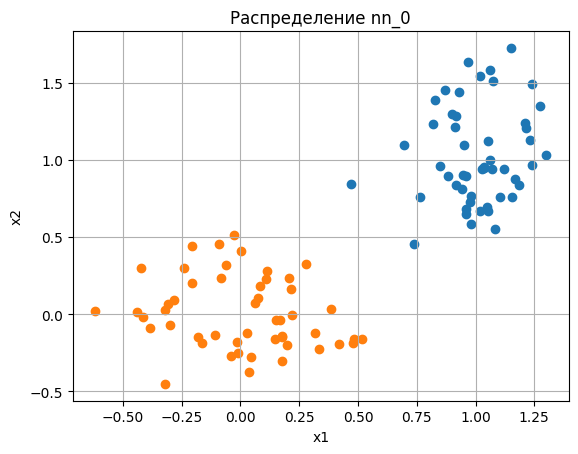

In [61]:
pos = df_0[df_0["class"] == 0]
plt.scatter(
    x=pos["x1"],
    y=pos["x2"],
    marker='o'
)
pos = df_0[df_0["class"] == 1]
plt.scatter(
    x=pos["x1"],
    y=pos["x2"],
    marker='o'
)
plt.title("Распределение nn_0")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.savefig(f"{pics_folder}/0/hist.png")

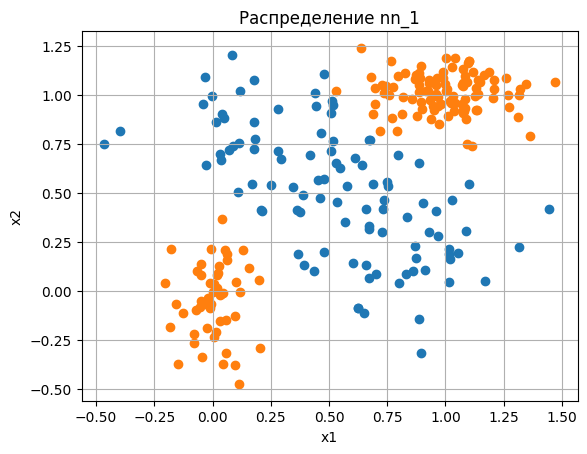

In [63]:
pos = df_1[df_1["class"] == 0]
plt.scatter(
    x=pos["x1"],
    y=pos["x2"],
    marker='o'
)
pos = df_1[df_1["class"] == 1]
plt.scatter(
    x=pos["x1"],
    y=pos["x2"],
    marker='o'
)
plt.title("Распределение nn_1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.savefig(f"{pics_folder}/1/hist.png")